In [1]:
import torch
import torch.nn as nn
from NoisePredictNet import NoisePredictor  # 确保导入你的模型类
from guidance_diff import GuidanceDenoiseDiffusion

def vocab_embedding(vocabs, len_seq, device):
    # 词嵌入
    vocab_to_idx = {"cos": 0, "sin": 1}
    indices = [vocab_to_idx[word] for word in vocabs]
    # 根据索引生成全0或全1的列表
    expanded_indices = [torch.full((len_seq,), idx, dtype=torch.long, device=device) for idx in indices]
    # 将列表转换为tensor
    indices_tensor = torch.stack(expanded_indices)
    return indices_tensor

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建模型实例
len_seq = 32
vocab_size = 2
n_steps = 1000
model = NoisePredictor(len_seq, vocab_size, device).to(device)
diffusion = GuidanceDenoiseDiffusion(n_steps=n_steps, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.load_state_dict(torch.load('./results_step1000_epoch500000/model.pt', map_location=device))
model.eval()

NoisePredictor(
  (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (time_mlp): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): SiLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (layer): Sequential(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): Dropout(p=0.15, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=96, out_features=96, bias=True)
    (4): Dropout(p=0.15, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=96, out_features=96, bias=True)
  )
  (net): Sequential(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): Dropout(p=0.15, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=96, out_features=64, bias=True)
    (4): Dropout(p=0.15, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
  )
)

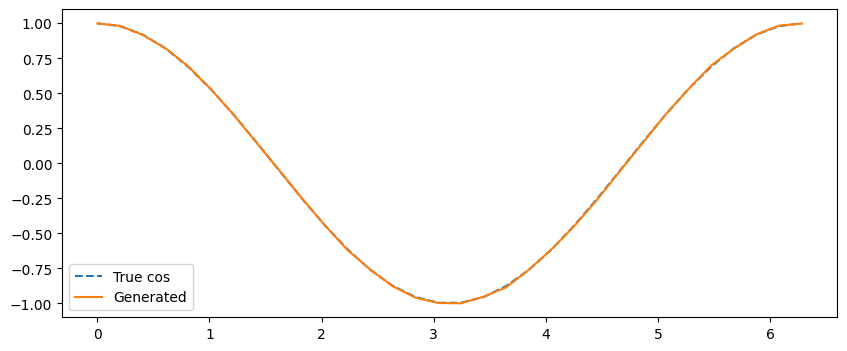

In [4]:
import numpy as np
from matplotlib import pyplot as plt

# 进行推理
with torch.no_grad():
    # 去噪纯噪声
    gen = torch.randn(1, len_seq).to(device)
    for t in range(n_steps - 1, -1, -1):
        t = torch.full((1,), t, device=device)
        gen = diffusion.p_sample(model, gen, t, vocab_embedding(['cos'], len_seq, device))
    # 绘制结果
    plt.figure(figsize=(10, 4))
    x = np.linspace(0, 2 * np.pi, len_seq)
    plt.plot(x, np.cos(x), '--', label='True cos')
    plt.plot(x, gen[0].cpu().numpy(), label='Generated')
    plt.legend()
    plt.show()





